# COVID-19 data

- Notes of patients with the diagnosis `COVID-19, virus geïdentificeerd \[U07.1]`.
- The data is from 2020 and Q1 of 2021.
- The data is from the two locations of the Amsterdam UMC: `amc` and `vumc`.

In [1]:
import pandas as pd

import sys
sys.path.insert(0, '..')
from utils.latex import show_latex
from utils.config import PATHS

In [2]:
pd.set_option('max_colwidth', None)

# Load data

- To see how the `covid_data_with_text.pkl` file was created, see `covid_data_prep.ipynb`.
- For stats about the data see `covid_data_stats.ipynb`.

In [3]:
datapath = PATHS.getpath('data_covid')
df = pd.read_pickle(datapath / 'covid_data_with_text.pkl')

df.Notitiedatum = pd.to_datetime(df.Notitiedatum)

In [4]:
domains=['ADM', 'ATT', 'BER', 'ENR', 'ETN', 'FAC', 'INS', 'MBW', 'STM']
levels = [f"{domain}_lvl" for domain in domains]

# Data selection for annotation

## Definitions
- Discharge date: after this date there are at least 2 days without any notes
- 1st follow-up: between 70-110 days after discharge
- 2nd follow-up: between 160-200 days after discharge

## BATCH 1

### Patient selection
1. Have notes on at least 5 unique dates
1. Have both the 1st and the 2nd follow-ups
1. No more than 100 notes per patient

In [5]:
# create time_df with discharge date, first follo-up, second follow-up

timedelta = pd.Timedelta(2, unit='D')
subset = ['MDN', 'Notitiedatum']

def get_discharge_date(df):
    cond = lambda df: df.delta_note_dates > timedelta
    s = df[cond].groupby('MDN').Notitiedatum.min()
    return df.MDN.replace(s)

def has_follow_up(df, start, end):
    start = pd.Timedelta(start, unit='D')
    end = pd.Timedelta(end, unit='D')
    within_period = lambda i: start <= i <= end
    has_period = lambda s: s.apply(within_period).any()
    return df.groupby('MDN').delta_discharge_date.transform(has_period)

s = df.groupby('MDN').Notitiedatum.nunique()[lambda s: s >= 5]
time_df = df.query(
    'MDN in @s.index'
).drop_duplicates(subset=subset)[subset].sort_values(subset).assign(
    date_next_note = lambda df: df.groupby('MDN').Notitiedatum.shift(-1),
    delta_note_dates = lambda df: df.date_next_note - df.Notitiedatum,
).loc[
    lambda df: df.groupby('MDN').delta_note_dates.transform(max) > timedelta
].assign(
    discharge_date = get_discharge_date,
    delta_discharge_date = lambda df: df.Notitiedatum - df.discharge_date,
    first_follow_up = lambda df: df.pipe(has_follow_up, start=70, end=110),
    second_follow_up = lambda df: df.pipe(has_follow_up, start=160, end=200),
)

In [6]:
# select patients with both follow-ups and no more than 100 notes

both_follow_ups = time_df.first_follow_up & time_df.second_follow_up
pts = time_df.loc[both_follow_ups].MDN.unique()
s = df.query("MDN in @pts").groupby('MDN').NotitieID.size()
s = s.loc[lambda s: s <= 100]
len(s)

153

<AxesSubplot:>

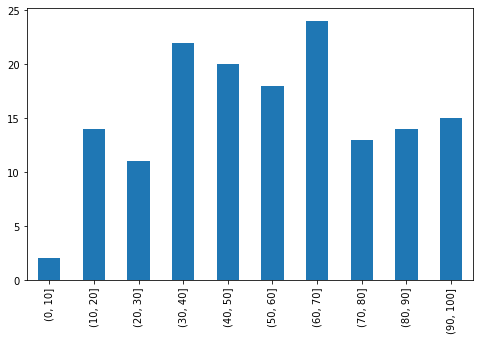

In [7]:
# distribution

bins = range(0,110,10)
pd.cut(s, bins=bins).value_counts(sort=False).plot.bar(figsize=(8,5))

### Notes

In [8]:
# total number of notes

selection = df.query("MDN in @s.index")
selection.shape[0]

8416

In [9]:
# notes with labels (gold / predicted)

df_any_lvl = selection.assign(any_lvl = selection[levels].any(axis=1))
totals = df_any_lvl.groupby('annotated').any_lvl.sum().rename('Total notes with label(s)')
totals['Total'] = df_any_lvl.any_lvl.sum()

table = selection.pivot_table(
    index = 'annotated',
    values = levels,
    aggfunc = 'count',
).T
table['Total'] = table.sum(axis=1)
table = table.append(totals)
table.pipe(show_latex, caption='na', label='na')

annotated,False,True,Total
ADM_lvl,"3,813",173,"3,986"
ATT_lvl,108,17,125
BER_lvl,301,16,317
ENR_lvl,909,67,976
ETN_lvl,"1,079",50,"1,129"
FAC_lvl,934,45,979
INS_lvl,708,69,777
MBW_lvl,535,43,578
STM_lvl,981,38,"1,019"
Total notes with label(s),"4,782",207,"4,989"


### Save files

- Every Excel file contains the notes of one patient, in a chronological order.
- The `levels` columns (e.g. `ADM_lvl`) are empty.

In [46]:
for mdn in selection.MDN.unique():
    recs = selection.query("MDN == @mdn").sort_values('Notitiedatum').iloc[:, :7].join(pd.DataFrame(columns=levels))
    filename = f'{mdn}-n.recs-{recs.shape[0]}.xlsx'

    path = PATHS.getpath('data_timeseries_annot')
    recs.to_excel(path / filename, index=False)